In [1]:
import pickle

In [2]:
import numpy as np

In [3]:
with open('train_qa.txt','rb') as f:
    train_data = pickle.load(f)
    
with open('test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [4]:
type(test_data)

list

In [5]:
type(train_data)

list

In [6]:
len(test_data)

1000

In [7]:
len(train_data)

10000

In [8]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [9]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [10]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [11]:
train_data[0][2]

'no'

In [12]:
all_data = test_data + train_data

In [13]:
len(all_data)

11000

In [14]:
vocab = set()
for story,question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [15]:
vocab.add('no')

In [16]:
vocab.add('yes')

In [17]:
vocab_len = len(vocab) + 1

In [18]:
vocab_len

38

In [19]:
# Longest Story
all_story_lens = [len(data[0]) for data in all_data]

In [20]:
max_story_len = max(all_story_lens)

In [21]:
max_question_len = max([len(data[1]) for data in all_data])


In [22]:
max_question_len

6

In [23]:
max_story_len

156

In [24]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [25]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [26]:
tokenizer.word_index

{'got': 1,
 'to': 2,
 'back': 3,
 'is': 4,
 'garden': 5,
 'discarded': 6,
 'office': 7,
 'left': 8,
 'dropped': 9,
 'kitchen': 10,
 'the': 11,
 'there': 12,
 'journeyed': 13,
 'apple': 14,
 'travelled': 15,
 'mary': 16,
 'went': 17,
 'bathroom': 18,
 'hallway': 19,
 'picked': 20,
 'yes': 21,
 'milk': 22,
 'bedroom': 23,
 'put': 24,
 'moved': 25,
 'grabbed': 26,
 'football': 27,
 'daniel': 28,
 'took': 29,
 'up': 30,
 'in': 31,
 '?': 32,
 '.': 33,
 'down': 34,
 'no': 35,
 'john': 36,
 'sandra': 37}

In [27]:
train_story_text = []
train_question_text = []
train_answers = []


In [28]:
for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [29]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [30]:
len(train_story_seq)

10000

In [31]:
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):
    #Stories
    X = []
    # Question
    Xq = []
    # Y question Answer (yes/no)
    Y = []
    
    for story,query,answer in data:
        # for each story
        # [23,16,......]
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    
    return(pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len),np.array(Y))

In [32]:
inputs_train, queries_train, answer_train = vectorize_stories(train_data)

In [33]:
inputs_test, queries_test, answer_test = vectorize_stories(test_data)

In [34]:
inputs_test

array([[ 0,  0,  0, ..., 11, 23, 33],
       [ 0,  0,  0, ..., 11,  5, 33],
       [ 0,  0,  0, ..., 11,  5, 33],
       ...,
       [ 0,  0,  0, ..., 11, 14, 33],
       [ 0,  0,  0, ..., 11,  5, 33],
       [ 0,  0,  0, ..., 14, 12, 33]])

In [35]:
tokenizer.word_index['yes']

21

In [36]:
tokenizer.word_index['no']

35

In [37]:
sum(answer_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 497.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 503.,   0.,   0.])

In [38]:
from keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding
from keras.layers import Input,Activation,Dense, Permute, Dropout,add, dot,concatenate, LSTM

In [39]:
# Placeholder
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [40]:
# vocab len
vocab_size = len(vocab) + 1

In [41]:
# Input encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))


In [42]:
# Input encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))


In [43]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [44]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [45]:
match = dot([input_encoded_m,question_encoded],axes=(2,2))
match = Activation('softmax')(match)

In [46]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [47]:
answer = concatenate([response,question_encoded])

In [48]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [49]:
answer = LSTM(32)(answer)

In [50]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [51]:
answer = Activation('softmax')(answer)

In [52]:
model = Model([input_sequence,question],answer)

In [53]:
model.compile(optimizer = 'rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [54]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [55]:
history = model.fit([inputs_train,queries_train],answer_train,batch_size=32,epochs=25,validation_data=([inputs_test,queries_test],answer_test))

Epoch 1/25
313/313 [==============================] - 8s 15ms/step - loss: 0.8658 - accuracy: 0.4956 - val_loss: 0.6942 - val_accuracy: 0.4970
Epoch 2/25
313/313 [==============================] - 4s 13ms/step - loss: 0.7010 - accuracy: 0.5026 - val_loss: 0.7045 - val_accuracy: 0.4970
Epoch 3/25
313/313 [==============================] - 6s 18ms/step - loss: 0.6955 - accuracy: 0.5049 - val_loss: 0.6945 - val_accuracy: 0.4970
Epoch 4/25
313/313 [==============================] - 6s 20ms/step - loss: 0.6947 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 5/25
313/313 [==============================] - 5s 17ms/step - loss: 0.6948 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 6/25
313/313 [==============================] - 5s 14ms/step - loss: 0.6949 - accuracy: 0.5005 - val_loss: 0.6955 - val_accuracy: 0.5030
Epoch 7/25
313/313 [==============================] - 4s 14ms/step - loss: 0.6944 - accuracy: 0.5028 - val_loss: 0.6938 - val_accuracy: 0.4970

In [56]:
filename = 'chatbot_model.h5'
model.save(filename)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


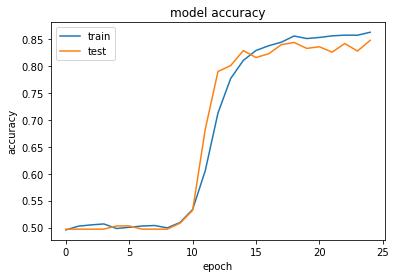

<Figure size 432x288 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.savefig('screenshot.png',bbox_inches='tight')

In [58]:
pred_results = model.predict(([inputs_test,queries_test]))

32/32 [==============================] - 1s 5ms/step


In [59]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [60]:
pred_results.shape[0]

1000

In [61]:
val_max = np.argmax(pred_results[0])

In [62]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [63]:
k

'no'

In [64]:
pred_results[0][val_max]

0.98957235

In [65]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [99]:
my_story = "John Left the kitchen . Sandra dropped the football in the garden"

In [100]:
my_story.split()

['John',
 'Left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden']

In [110]:
my_question = "Is the football in the garden ?"

In [111]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [112]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [113]:
my_story, my_ques, my_answ = vectorize_stories(mydata) 

In [114]:
my_answ

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

In [115]:
pred_results = model.predict(([my_story, my_ques]))

1/1 [==============================] - 0s 22ms/step


In [116]:
val_max  = np.argmax(pred_results[0])

In [117]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [118]:
k

'no'